# Numerical exploration of the distribution moments for mRNA and protein.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import glob
import pickle
import dill
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$

# Exploring the mRNA and protein distribution moments

Now that we have computed the mRNA and protein distribution moments for the two- and the three-state promoter let's numerically explore the analytical results.

## Import `lambdify` functions using `dill`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `dill` library. Let's now import these functions into this notebook to make use of them.

In [2]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

In [3]:
# Import two-state protein moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'two_state_protein_lambdify.dill', 'rb') as file:
    first_unreg_p = dill.load(file)
    second_unreg_p = dill.load(file)
    
# Import two-state protein moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'three_state_protein_lambdify.dill', 'rb') as file:
    first_reg_p = dill.load(file)
    second_reg_p = dill.load(file)

# Defining fano-factor and $\eta^2$ function.

Two interesting quantities is worth exploring is the fano-factor (variance / mean) and the noise-square function $\eta^2$ (variance / mean$^2$). Each of them have their experimental and theoretical advantages as discussed elsewhere.

Let's define a function that computes these quantities.

In [4]:
def fano_unreg_m(kp_on, kp_off, rm, gm):
    '''
    Computes the fano-factor (variance / mean) for a two-state unregulated promoter
    at the mRNA level
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    Returns
    -------
    mRNA fano-factor for an unregulated promoter.
    '''
    return (second_unreg_m(kp_on, kp_off, rm, gm) -\
            first_unreg_m(kp_on, kp_off, rm, gm)**2) /\
            first_unreg_m(kp_on, kp_off, rm, gm)

In [6]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=0.017, kp_off=0.132, rm=0.354, gm=0.00284)

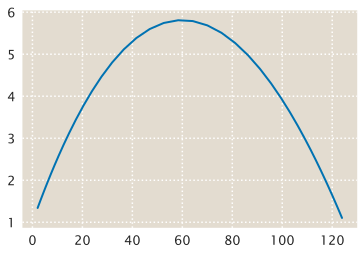

In [16]:
kp_off_array = np.logspace(-4,0)

par = par_UV5
par['kp_off'] = kp_off_array

plt.plot(first_unreg_m(*par.values()), fano_unreg_m(**par))

# Compare two-state promtoer protein noise with Shahrezaei & Swain

Shahrezaei & Swain in their 2008 paper derived an expression for the noise in protein copy numbers of the form
\begin{equation}
\eta^2 = \frac{1}{\langle p \rangle} + \frac{\gp}{\gm} \frac{1}{\langle m \rangle} + \frac{\gp}{\gp + \kpon + \kpoff} \frac{\kpoff}{\kpon}.
\end{equation}

This is derived under the assumption that $\gm \gg \gp$. Let's compare this with the complete analytical result as obtained by computing the moments directly from the master equation.

Let's define both functions to compute the S & S approximation and the full form of the noise.

In [18]:
def noise_unreg_swain(kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the noise (variance / mean**2) for a two-state unregulated promoter
    at the protein level as derived by Shahrezaei & Swain PNAS 2008. This
    approximation is valid for gm >> gp.
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Returns
    -------
    protein noise for an unregulated promoter.
    '''
    # Compute the mean mRNA
    mean_m = (rm / gm) * kp_on / (kp_on + kp_off)
    # Compute the mean protein
    mean_p = (rp / gp) * mean_m
    
    return 1 / mean_p + (gp / gm) * (1 / mean_m) +\
           gp / (gp + kp_on + kp_off) * (kp_off / kp_on)

In [21]:
def noise_unreg_p(kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the noise (variance / mean**2) for a two-state unregulated promoter
    at the protein level.
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Returns
    -------
    protein noise for an unregulated promoter.
    '''
    return second_unreg_p(kp_on, kp_off, rm, gm, rp, gp) /\
           first_unreg_p(kp_on, kp_off, rm, gm, rp, gp)**2 - 1

Having defined the functions let's compare them for different values of $\gp$ using the most likely parameters for the *lacUV5* promoter.

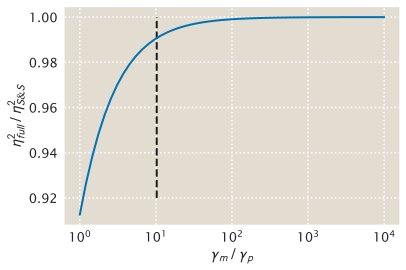

In [45]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=0.017, kp_off=0.132, rm=0.354, gm=0.00284,
               gp=0.000277)
# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

# Define a range of gm / gp ratios
gamma = np.logspace(0, 4) # gm / gp

# Copy the UV5 parameters and modify gp
par = par_UV5.copy()
par['gp'] = par['gp'] / gamma

# Plot the ratio of noises
plt.plot(gamma, noise_unreg_p(**par) / noise_unreg_swain(**par))
# Indicate with vertical line the most likely value of the gm / gp ratio
plt.vlines(par_UV5['gm'] / par_UV5['gp'], 0.92, 1, linestyle='--')
# Label plot
plt.xscale('log')
plt.xlabel(r'$\gamma_m \; / \; \gamma_p$')
_ = plt.ylabel(r'$\eta^2_{full} \; / \; \eta^2_{S&S}$')

From this plot we can see that Shahrezaei & Swain's approximation works the best as the assumption of $\gm \gg \gp$ is better satisfied. From the vertical line we can see that for our assumption the approximation is already very accurate.